In [2]:
%matplotlib notebook

import os
import sys
sys.path.append("lib") # go to parent dir

import tensorflow as tf
from tensorflow import keras

import numpy as np
import scipy as sp
import nibabel as nib
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import lib.motion as motion
import lib.models as models


W1003 09:05:02.061913 140257251444480 deprecation_wrapper.py:119] From /data/vision/polina/scratch/nmsingh/dev/Motion-Experiments/lib/models.py:4: The name tf.keras.layers.CuDNNGRU is deprecated. Please use tf.compat.v1.keras.layers.CuDNNGRU instead.

W1003 09:05:02.063038 140257251444480 deprecation_wrapper.py:119] From /data/vision/polina/scratch/nmsingh/dev/Motion-Experiments/lib/models.py:4: The name tf.keras.layers.CuDNNLSTM is deprecated. Please use tf.compat.v1.keras.layers.CuDNNLSTM instead.



In [3]:
n = 64
batch_size = 100

# Set up model
model = models.get_full_model(n)
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
model.load_weights('training/IMAGENET-CLEAN-STANDARD-False-500epoch-64/cp-0355.ckpt')

W1003 09:05:02.099668 140257251444480 deprecation.py:506] From /data/vision/polina/scratch/nmsingh/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
# Set up corrupted brain model
corrupted_brain_model = models.get_full_model(n)
corrupted_brain_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
corrupted_brain_model.load_weights('training/batch100-BRAIN-ALL-ALL-PATCHFalse-STANDARD-relu-FREQUENCY_INDOMAIN-IMAGE_OUTDOMAIN-False-500epoch-64/cp-0150.ckpt')

In [5]:
# Set up brain convolutional model
conv_brain_model = models.get_conv_model(n, (n,n,2))
conv_brain_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
conv_brain_model.load_weights('training/batch100-BRAIN-ALL-ALL-PATCHFalse-CONV-relu-FREQUENCY_INDOMAIN-IMAGE_OUTDOMAIN-False-500epoch-64/cp-0500.ckpt')

In [6]:
# Set up UNet model
unet_brain_model = models.get_Unet(n,'relu', (n,n,2))
unet_brain_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
unet_brain_model.load_weights('training/batch100-BRAIN-ALL-ALL-PATCHFalse-UNET-relu-FREQUENCY_INDOMAIN-FREQUENCY_OUTDOMAIN-False-500epoch-64/cp-0055.ckpt')

In [7]:
# Set up UNet model
unet_img_brain_model = models.get_Unet(n,'relu', (n,n,1))
unet_img_brain_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
unet_img_brain_model.load_weights('training/batch100-BRAIN-ALL-ALL-PATCHFalse-UNET-relu-IMAGE_INDOMAIN-IMAGE_OUTDOMAIN-False-500epoch-64/cp-0115.ckpt')

In [31]:
# Set up LC model
lc_brain_model = models.get_local_conv_freq_model(n)
lc_brain_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
lc_brain_model.load_weights('training/BRAIN-ALL-ALL-PATCHFalse-LC_FREQUENCY-custom-FREQUENCY_INDOMAIN-FREQUENCY_OUTDOMAIN-False-500epoch-64-*locally-connected-freq2freq-lingaussdiff/cp-0500.ckpt')

In [32]:
def get_plotting_data(angle,num_pix,k_line,data_dir,ind):
    data_path = data_dir+os.listdir(data_dir)[ind]
    vol_data = np.load(data_path)['vol_data']
    _,_,z = vol_data.shape

    img_data = vol_data[:,:,int(z/2)]
    img_data = np.array(Image.fromarray(img_data).resize((n,n)))
    img_data = img_data-img_data.mean()
    img_data = img_data/np.max(img_data)

    corrupted_img,corrupted_k_raw = motion.add_rotation_and_translation(img_data,angle,num_pix,return_k=True)

    corrupted_k_all = np.expand_dims(corrupted_k_raw,-1)
    corrupted_k_re = np.real(corrupted_k_all)
    corrupted_k_im = np.imag(corrupted_k_all)
    corrupted_k = np.expand_dims(np.concatenate([corrupted_k_re,corrupted_k_im], axis=2), axis=0) 
    return img_data, corrupted_img, corrupted_k

<IPython.core.display.Javascript object>


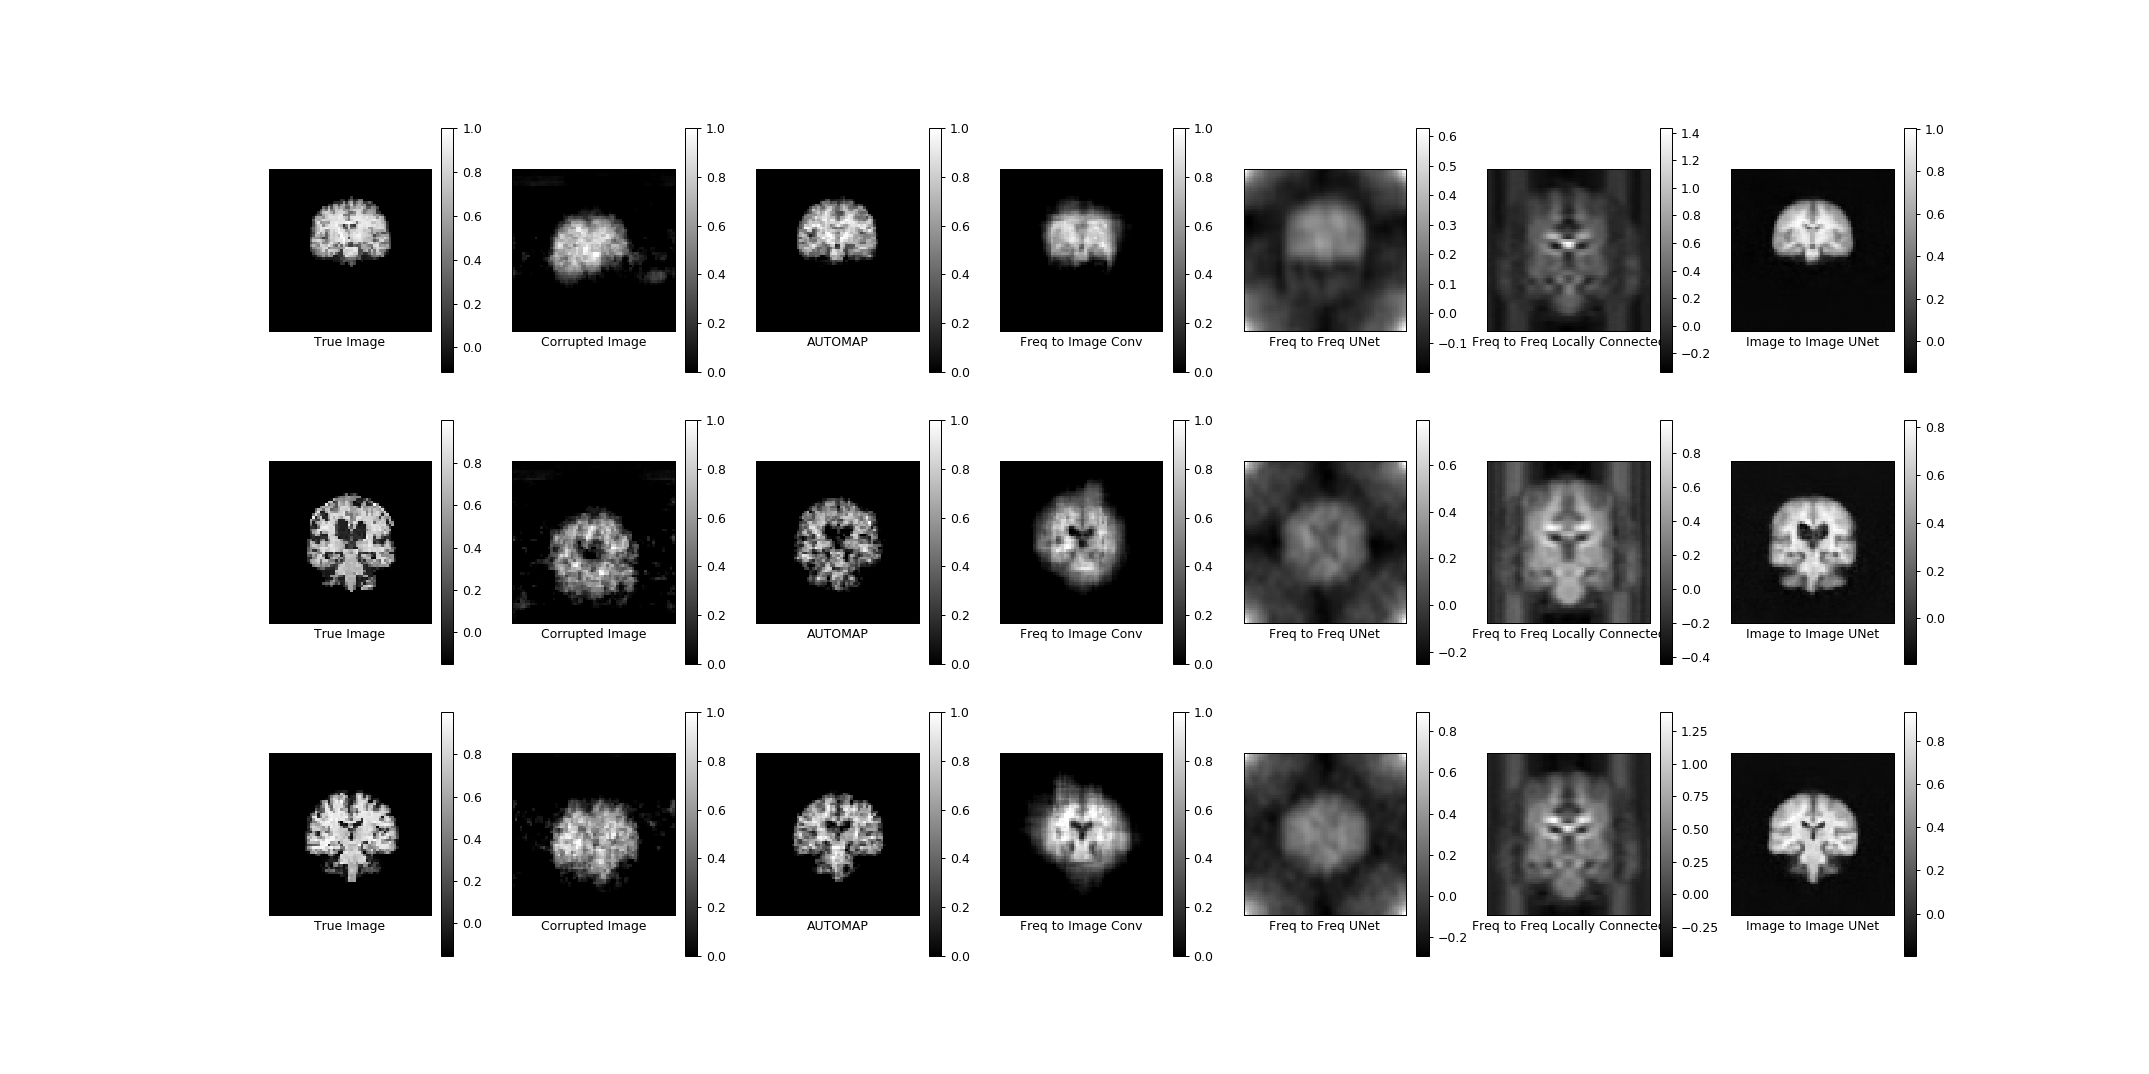

In [33]:
data_dir = '/data/ddmg/voxelmorph/data/t1_mix/proc/old/resize256-crop_0/test/vols/'
num_imgs = 3
num_panels = 7

suffix = ' px-translation'

fig,axes = plt.subplots( num_imgs, num_panels, figsize=[24,4*num_imgs] )

img_datas = []
corrupted_imgs = []
corrupted_ks = []

for i in range(num_imgs):
    num_corrupt=64
    num_pix = np.random.randint(0,10,size=num_corrupt)
    angle = np.random.randint(0,45,size=num_corrupt)
    k_line = 10
    img_data, corrupted_img, corrupted_k = get_plotting_data(angle,num_pix,k_line,data_dir,i)
    img_datas.append(img_data)
    corrupted_imgs.append(corrupted_img)
    corrupted_ks.append(corrupted_k)

for i,iax in enumerate(axes.flatten()):
    subj = int(i/num_panels)
    img_data = img_datas[subj]
    corrupted_img = corrupted_imgs[subj]
    corrupted_k = corrupted_ks[subj]
    
    if i%num_panels==0:
        true_img = np.rot90(img_data, axes=(1,0))
        im = iax.imshow(true_img,cmap='gray')
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('True Image')
        plt.colorbar(im,ax=iax)
    elif i%num_panels==1:
        plot_corrupted_img = np.rot90((np.real(corrupted_img)), axes=(1,0))
        im = iax.imshow(plot_corrupted_img,cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Corrupted Image')
        plt.colorbar(im,ax=iax)
    elif i%num_panels==2:
        corrupted_predict = np.rot90(corrupted_brain_model.predict(corrupted_k)[0,:,:,0], axes=(1,0))
        im = iax.imshow(np.real(corrupted_predict),cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('AUTOMAP')
        plt.colorbar(im,ax=iax)
    elif i%num_panels==3:
        corrupted_predict = np.rot90(conv_brain_model.predict(corrupted_k)[0,:,:,0], axes=(1,0))
        im = iax.imshow(corrupted_predict,cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Freq to Image Conv')
        plt.colorbar(im,ax=iax)
    elif i%num_panels==4:
        unet_reconstruction = np.real(np.fft.ifft2(np.fft.ifftshift(unet_brain_model.predict(corrupted_k)[0,:,:,0]+1j*unet_brain_model.predict(corrupted_k)[0,:,:,1])))
        unet_predict = np.rot90(unet_reconstruction, axes=(1,0))
        im = iax.imshow(np.real(unet_predict),cmap='gray')
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Freq to Freq UNet')
        plt.colorbar(im,ax=iax)
    elif i%num_panels==5:
        lc_reconstruction = np.real(np.fft.ifft2(np.fft.ifftshift(lc_brain_model.predict(corrupted_k)[0,:,:,0]+1j*lc_brain_model.predict(corrupted_k)[0,:,:,1])))
        lc_predict = np.rot90(lc_reconstruction, axes=(1,0))
        im = iax.imshow(np.real(lc_predict),cmap='gray')
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Freq to Freq Locally Connected')
        plt.colorbar(im,ax=iax)
    elif i%num_panels==6:
        unet_reconstruction = np.real(unet_img_brain_model.predict(np.expand_dims(np.expand_dims(corrupted_img,-1),0)))
        unet_predict = np.rot90(unet_reconstruction[0,:,:,0], axes=(1,0))
        im = iax.imshow(np.real(unet_predict),cmap='gray')
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Image to Image UNet')
        plt.colorbar(im,ax=iax)
plt.savefig('examples.png')